In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
data_folder = "raw_data"

first_ecg = np.load(data_folder + "/first_ecg.npy")
first_ppg = np.load(data_folder + "/first_ppg.npy")

second_ecg = np.load(data_folder + "/second_ecg.npy")
second_ppg = np.load(data_folder + "/second_ppg.npy")

third_ecg = np.load(data_folder + "/third_ecg.npy")
third_ppg = np.load(data_folder + "/third_ppg.npy")

In [3]:
print("First ECG shape:", first_ecg.shape)
print("First PPG shape:", first_ppg.shape)
print("Second ECG shape:", second_ecg.shape)
print("Second PPG shape:", second_ppg.shape)
print("Third ECG shape:", third_ecg.shape)
print("Third PPG shape:", third_ppg.shape)

First ECG shape: (112000,)
First PPG shape: (2063,)
Second ECG shape: (114000,)
Second PPG shape: (2861,)
Third ECG shape: (109000,)
Third PPG shape: (2703,)


In [53]:
from scipy.signal import find_peaks

def find_frequency(data, threshold):
    # Peaks finden, die einen Schwellenwert überschreiten
    peaks, _ = find_peaks(data, height=threshold)

    # Zeiten der Peaks extrahieren
    peak_times = peaks

    # Intervalle zwischen den Peaks berechnen
    peak_intervals = np.diff(peak_times)

    return np.median(peak_intervals)

In [54]:
find_frequency(first_ecg, 1350)

807.0

In [64]:
# Zeitschritte * durchschnittlicher Herzschlag pro Minute / Sekunden einer Minute = sampling frequency in Hz
807 * 65 / 60

874.25

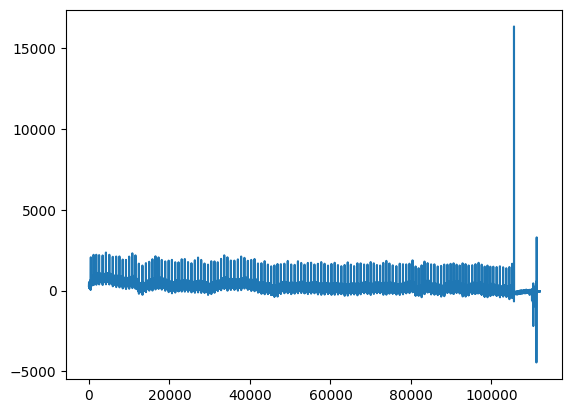

In [50]:
plt.plot(first_ecg)

In [59]:
# Peaks finden
peaks, _ = find_peaks(first_ppg)

# Zeiten der Peaks extrahieren
peak_times = peaks

# Intervalle zwischen den Peaks berechnen
peak_intervals = np.diff(peak_times)

np.median(peak_intervals)

24.0

In [63]:
# PPG Zeitschritte * durchschnittlicher Herzschlag pro Minute / Sekunden einer Minute = sampling frequency in Hz
24 * 65 / 60

26.0

In [115]:
def compare_two_plots(data_original, data_transformed):
    # Erstelle zwei Subplots nebeneinander
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Erster Plot
    ax1.plot(data_original)
    ax1.set_title('original')

    # Zweiter Plot
    ax2.plot(data_transformed)
    ax2.set_title('transformed')

    # Zeige die Plots an
    plt.tight_layout()
    plt.show()

### Detrending

#### PPG

In [78]:
# Linear Detrending
def remove_trend(series, window):
    rolling_mean = np.convolve(series, np.ones(window), 'valid') / window
    return series[window-1:] - rolling_mean

# Example usage
linear_detrended = remove_trend(first_ppg, window=6)


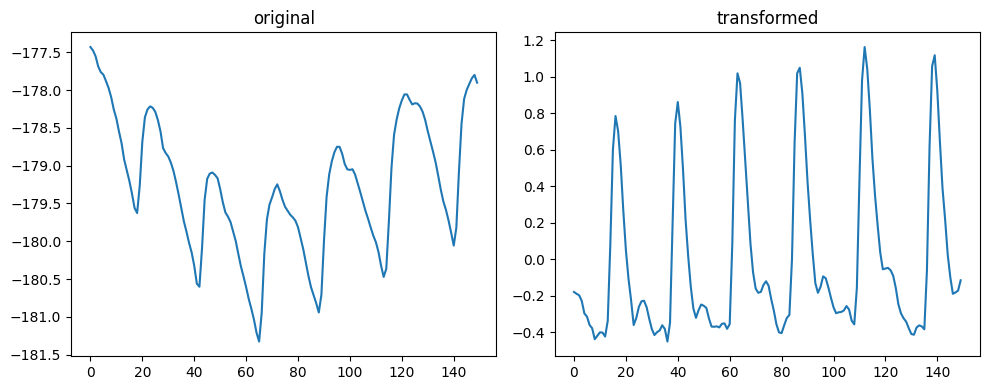

In [116]:
compare_two_plots(first_ppg[100:250], linear_detrended[100:250])

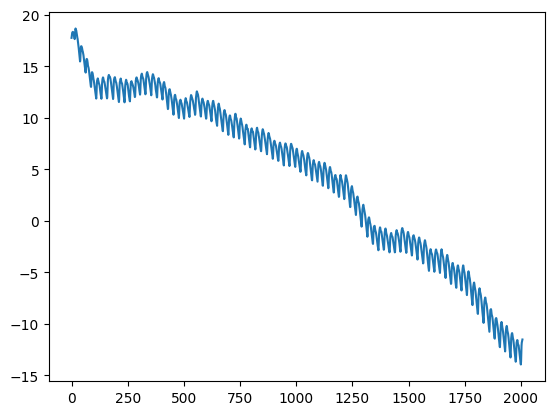

In [68]:
from scipy.signal import detrend
detrended_signal = detrend(first_ppg)

plt.plot(detrended_signal[55:])

In [76]:
# Detrending by differencing

def differencing(signal):
    detrended_signal = np.diff(signal, prepend=signal[0])
    return detrended_signal

# Example usage:
detrended_signal = differencing(first_ppg)

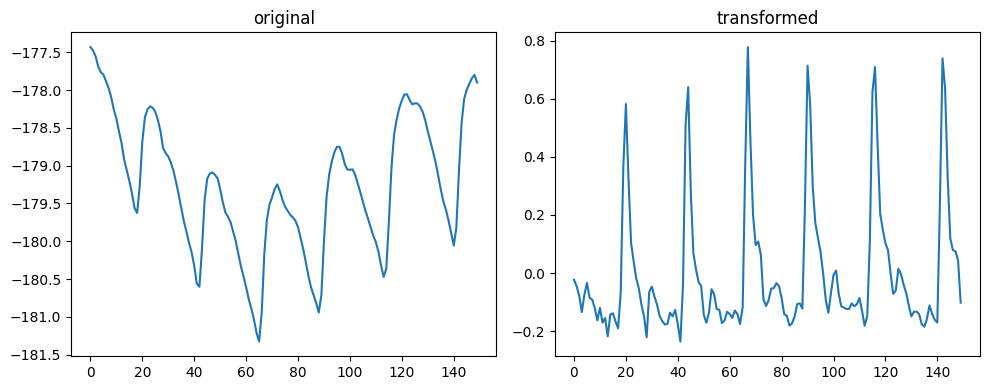

In [75]:
compare_two_plots(first_ppg[100:250], detrended_signal[100:250])

# Seems to work best !!

#### ECG

not necessary to remove trend

### Remove high-frequency noise and offset

#### PPG

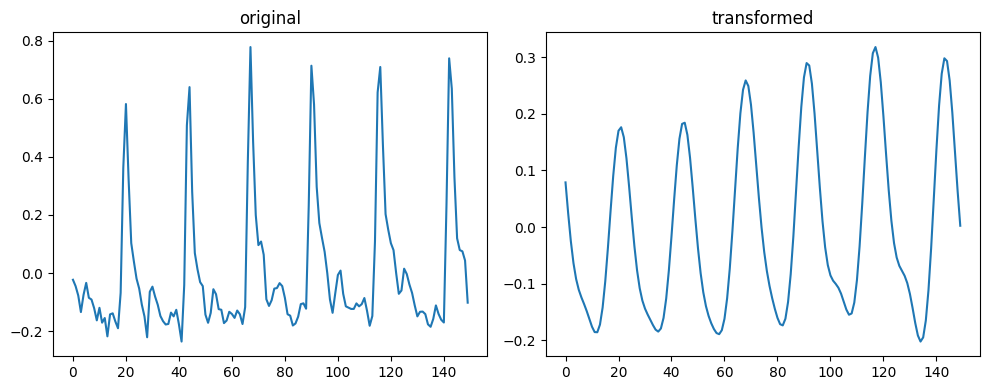

In [123]:
from scipy.signal import butter, filtfilt
# Design a low-pass filter
def lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y


ppg_fs = 26 # sampling frequency in Hz
cutoff = 2  # Cutoff frequency
filtered_signal_ppg = lowpass_filter(detrended_signal, cutoff, ppg_fs)

compare_two_plots(detrended_signal[100:250], filtered_signal_ppg[100:250])

#### ECG

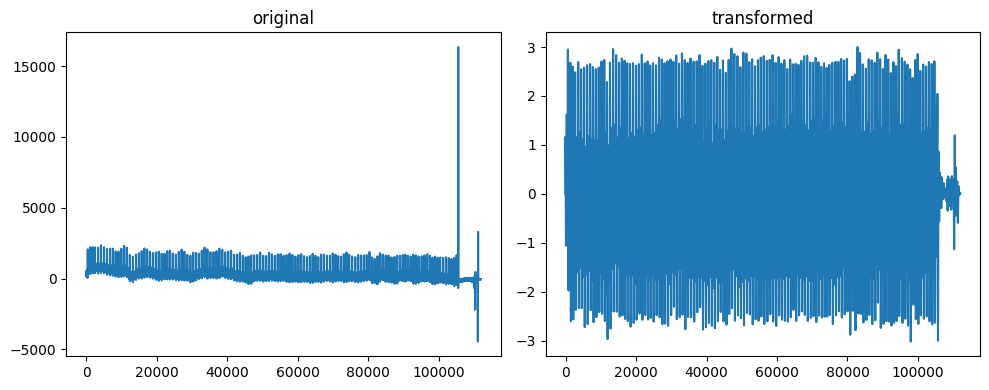

In [190]:
ecg_fs = 807 # sampling frequency in Hz # 807
cutoff = 2.8  # Cutoff frequency

filtered_signal_ecg = lowpass_filter(first_ecg, cutoff, ecg_fs)

detrended_filtered_signal_ecg = differencing(filtered_signal_ecg)

compare_two_plots(first_ecg, detrended_filtered_signal_ecg)

### 3. Pulse locations

#### PPG

In [129]:
# Peaks finden
peaks_ppg, _ = find_peaks(filtered_signal_ppg)

# Zeiten der Peaks extrahieren
peak_times_ppg = peaks_ppg

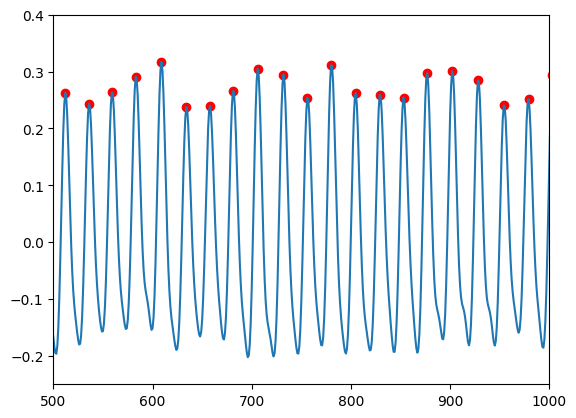

In [141]:
# line
plt.plot(filtered_signal_ppg)

y_values_ppg = [filtered_signal_ppg[i] for i in peak_times_ppg]
# scatter
plt.scatter(peak_times_ppg, y_values_ppg, color = "red")

plt.xlim(500, 1000)
plt.ylim(-0.25, 0.4)

plt.show()

### ECG

In [191]:
# Peaks finden
peaks_ecg, _ = find_peaks(detrended_filtered_signal_ecg)

# Zeiten der Peaks extrahieren
peak_times_ecg = peaks_ecg

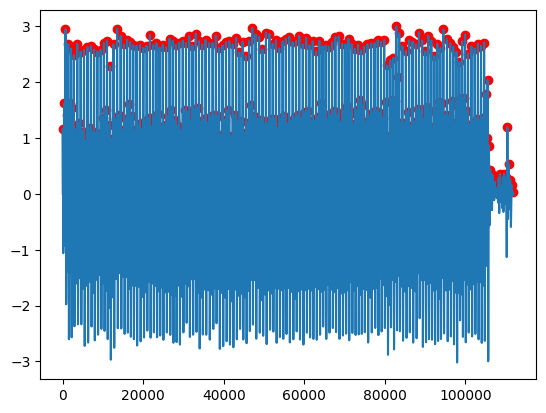

In [192]:
# line
plt.plot(detrended_filtered_signal_ecg)

y_values_ecg = [detrended_filtered_signal_ecg[i] for i in peak_times_ecg]
# scatter
plt.scatter(peak_times_ecg, y_values_ecg, color = "red")

#plt.xlim(0, 5000)
#plt.ylim(500, 1000)

plt.show()

## 4. Anomalies and outliers

### Outliers

In [135]:
def iqr_detection(signal):
    Q1 = np.percentile(signal, 25)
    Q3 = np.percentile(signal, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = np.where((signal < lower_bound) | (signal > upper_bound))
    return outliers

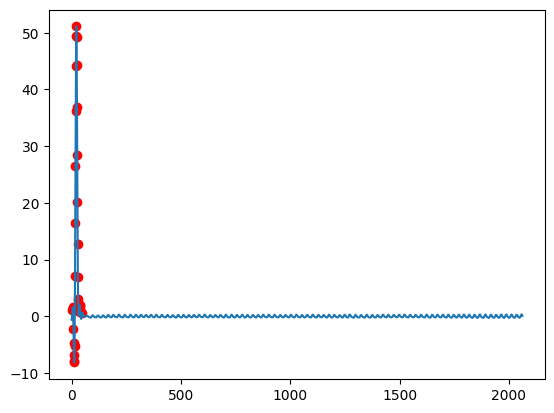

In [137]:
outliers = iqr_detection(filtered_signal_ppg)

# line
plt.plot(filtered_signal_ppg)

y_values = [filtered_signal_ppg[i] for i in outliers]
# scatter
plt.scatter(outliers, y_values, color = "red")

#plt.xlim(500, 1000)
#plt.ylim(-0.25, 0.4)

plt.show()


### Anomalies

In [ ]:
# use the peaks and compare to its neigbors, for ex. subtract and see if its above a threshold

# plus i can compare with mean and std for

In [139]:
peak_times_ppg

array([   6,   22,   37,   50,   63,   72,   96,  121,  145,  168,  191,
        217,  243,  269,  294,  318,  341,  364,  388,  413,  439,  463,
        488,  512,  536,  559,  583,  609,  634,  658,  681,  706,  732,
        756,  780,  805,  829,  853,  877,  902,  928,  954,  979, 1003,
       1029, 1054, 1078, 1103, 1129, 1153, 1177, 1202, 1226, 1249, 1273,
       1299, 1324, 1350, 1375, 1400, 1424, 1449, 1474, 1498, 1523, 1549,
       1574, 1598, 1624, 1649, 1674, 1698, 1723, 1748, 1771, 1794, 1818,
       1843, 1867, 1892, 1918, 1942, 1965, 1988, 2012, 2036, 2058])

In [151]:
median_diff_between_neighboring_peaks = abs(np.median(np.diff(y_values_ppg)))

# np.percentile(y_values_ppg, 75)

mean_diff_between_neighboring_peaks = abs(np.mean(np.diff(y_values_ppg)))

print(median_diff_between_neighboring_peaks)
print(mean_diff_between_neighboring_peaks)

0.0038869223898991556
0.014336157905224552


In [177]:
counter = 0
anomalies_x = []
anomalies_y = []
for peak_x, peak_y in zip(peak_times_ppg, y_values_ppg):
    if counter != 0 and counter != len(peak_times_ppg)-1:

        # detect peak that is very different to one of it's neighbors. I finetuned and used 8 times the median of the diffs
        if abs(y_values_ppg[counter-1] - peak_y) > median_diff_between_neighboring_peaks*8 and abs(y_values_ppg[counter+1] - peak_y) > median_diff_between_neighboring_peaks*8:
            anomalies_x.append(peak_x)
            anomalies_y.append(peak_y)



    counter += 1


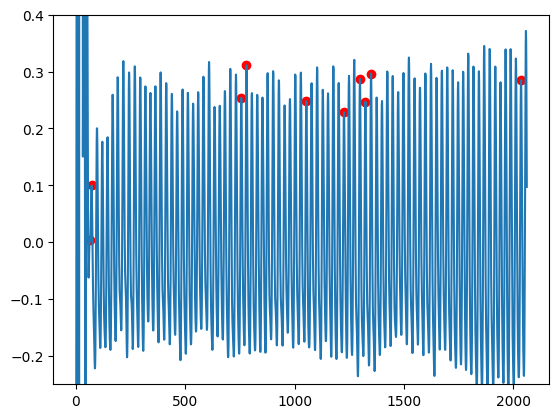

In [178]:
# line
plt.plot(filtered_signal_ppg)

# scatter
plt.scatter(anomalies_x, anomalies_y, color = "red")

#plt.xlim(500, 1000)
plt.ylim(-0.25, 0.4)

plt.show()

## 5. Synchronizing ECG and PPG

In [193]:
correlation = np.correlate(filtered_signal_ppg, detrended_filtered_signal_ecg, mode='full')
lag = np.argmax(correlation) - len(filtered_signal_ecg) + 1

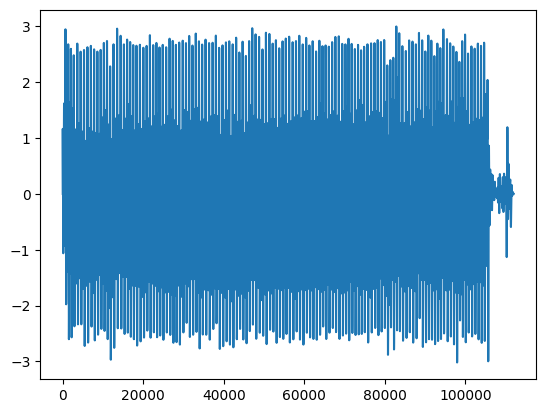

In [194]:
plt.plot(detrended_filtered_signal_ecg)

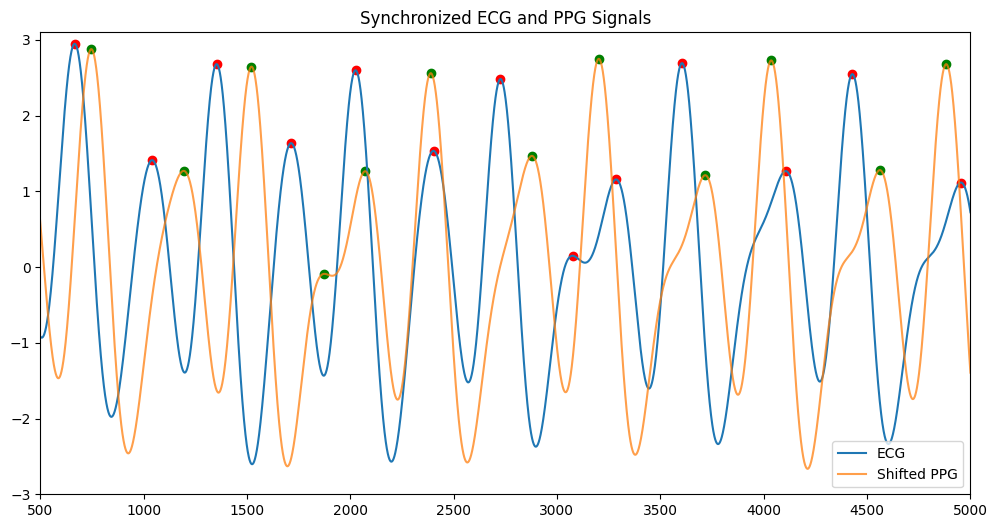

In [196]:
time_shift = lag / ecg_fs  # Convert lag to time shift in seconds

# Adjust PPG signal according to the time shift
shifted_ppg = np.roll(detrended_filtered_signal_ecg, lag)
shifted_ppg_peaks, _ = find_peaks(shifted_ppg, distance=ppg_fs/2.5)


plt.figure(figsize=(12, 6))
plt.plot(detrended_filtered_signal_ecg, label='ECG')
plt.plot(shifted_ppg, label='Shifted PPG', alpha=0.75)
plt.scatter(peak_times_ecg, detrended_filtered_signal_ecg[peak_times_ecg], color='red')
plt.scatter(shifted_ppg_peaks, shifted_ppg[shifted_ppg_peaks], color='green')
plt.legend()
plt.title('Synchronized ECG and PPG Signals')

plt.xlim(500, 5000)
plt.ylim(-3, 3.1)

plt.show()

## 6. Evaluation

In [197]:
def calculate_snr(signal):
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean((signal - np.mean(signal)) ** 2)
    return 10 * np.log10(signal_power / noise_power)

In [198]:
calculate_snr(first_ppg)

12.55027923568939

In [199]:
calculate_snr(second_ppg)

9.665629295957899

In [200]:
calculate_snr(third_ppg)

24.85720546509591